In [1]:
import numpy as np
import pandas as pd

import subprocess as sp
import MeCab

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec, KeyedVectors
from gensim.matutils import Sparse2Corpus

from xml.etree import ElementTree

%matplotlib inline

In [2]:
tree = ElementTree.parse('./inputs/lifelog_advice_corpus/lifelog_advice_corpus.xml')
root = tree.getroot()
# 属性の辞書のリストを作る
data = [{
    'lifelog_id': lifelog.get('id') , 
    'line_id': line.get('id'), 
    'text':text
} for lifelog in root.findall('.//lifelog') 
    for line in lifelog.findall('l_s') 
    for text in line.itertext()
]

In [3]:
lifelog_df = pd.DataFrame(data)
lifelog_text_df = lifelog_df.groupby(['lifelog_id', 'line_id'])[['text']].apply(
    lambda rec: np.sum(rec.text + ' ')
).reset_index(name='text')

In [4]:
neologd_path = sp.check_output(
    'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"', shell=True
)[:-1].decode('utf-8')
neologd_tagger = MeCab.Tagger("-d {} -Ochasen".format(neologd_path))

In [5]:
def parse_text(text: str):
    parsed_text = neologd_tagger.parse(text).split('\n')
    parsed_results = pd.Series(parsed_text).str.split('\t').tolist()
    df = pd.DataFrame.from_records(parsed_results)
    columns = ['surface', 'spell', 'orig', 'type', 'katsuyoukei', 'katsuyoukata']
    df.columns = columns
    return df.query("surface != 'EOS'").query("surface != ''")

In [6]:
def extract_noun(text: str):
    parsed = parse_text(text)
    noun_df = parsed[
        parsed.type.str.startswith('名詞-一般') | 
        parsed.type.str.startswith('名詞-サ変接続') 
    ]
    return ' '.join(noun_df.orig.tolist())

In [7]:
lifelog_text_df['bow'] = np.vectorize(extract_noun)(lifelog_text_df.text)

In [8]:
lifelog_bow_df = lifelog_text_df.groupby('lifelog_id')[['bow']].apply(
    lambda rec: np.sum(rec.bow + ' ')
).reset_index(name='bow')

In [9]:
w2v_vectors = Word2Vec.load('./inputs/word2vec.gensim.model')

In [10]:
def coherence_for_topic_n(topic_n: int, nmf: NMF, X: pd.Series, wv: KeyedVectors = w2v_vectors.wv) -> pd.DataFrame:
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\S+', norm='l1')
    tfidf = tfidf_vectorizer.fit_transform(X)
    word_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names()})
    nmf.set_params(n_components = topic_n)
    _ = nmf.fit_transform(tfidf)
    H = nmf.components_
    topY = 5
    topY_indices = H.argsort(axis=1)[:, :-(topY + 1):-1]
    topic_rank_index_df = pd.DataFrame(topY_indices).stack().reset_index()\
        .rename(columns={'level_0': 'topic', 'level_1': 'rank', 0: 'word_idx'})
    topic_rank_word_df = pd.merge(
        topic_rank_index_df,
        word_df,
        left_on='word_idx', right_index=True
    ).drop('word_idx', axis=1).sort_values(['topic', 'rank'])
    topics = topic_rank_word_df.groupby('topic')['word'].apply(lambda words: words.tolist()).tolist()
    corpus = Sparse2Corpus(tfidf)
    corpus_dict = Dictionary.from_corpus(corpus, word_df.to_dict()['word'])
    coherence_model = CoherenceModel(
        topics = topics,
        corpus = corpus,
        dictionary = corpus_dict,
        keyed_vectors = wv,
        coherence='c_w2v',
        topn=topY
    )
    result = {'n_components': topic_n, 'coherence': coherence_model.get_coherence()}
    return result

In [11]:
records = []
for topic_n in range(5, 16):
    nmf = NMF(alpha=0.01, init='random', l1_ratio=0.0, random_state=0)
    records.append(coherence_for_topic_n(topic_n, nmf, lifelog_bow_df.bow))

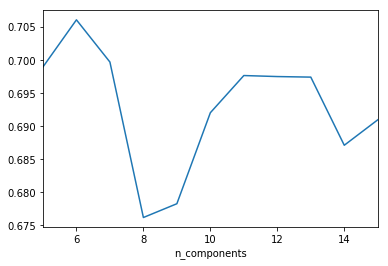

In [12]:
pd.DataFrame(records).set_index('n_components')['coherence'].plot()

In [13]:
def extract_topic_rank_word_df(topic_n: int, X: pd.Series):
    nmf = NMF(alpha=0.01, init='random', l1_ratio=0.0, random_state=0)
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\S+', norm='l1')
    tfidf = tfidf_vectorizer.fit_transform(X)
    word_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names()})
    nmf.set_params(n_components = topic_n)
    _ = nmf.fit_transform(tfidf)
    H = nmf.components_
    topY = 5
    topY_indices = H.argsort(axis=1)[:, :-(topY + 1):-1]
    topic_rank_index_df = pd.DataFrame(topY_indices).stack().reset_index()\
        .rename(columns={'level_0': 'topic', 'level_1': 'rank', 0: 'word_idx'})
    return pd.merge(
        topic_rank_index_df,
        word_df,
        left_on='word_idx', right_index=True
    ).drop('word_idx', axis=1).sort_values(['topic', 'rank'])


In [14]:
extract_topic_rank_word_df(6, lifelog_bow_df.bow).groupby('topic')['word'].apply(lambda words: words.tolist())

topic
0      [ご飯, 善, 体重, カロリー, コーヒー]
1    [風邪, 体, マスク, インフルエンザ, 電車]
2      [おにぎり, 熱, シャワー, 体調, 食欲]
3      [風呂, 帰り, シャワー, コンビニ, 体]
4        [サラダ, 食事, 大根, 白菜, 朝食]
5        [ストレッチ, 腰, 首, 肩, ポーズ]
Name: word, dtype: object

In [15]:
extract_topic_rank_word_df(8, lifelog_bow_df.bow).groupby('topic')['word'].apply(lambda words: words.tolist())

topic
0       [ご飯, 善, 体重, カロリー, コーヒー]
1         [ポテト, 口, サイズ, ご飯, 幼少]
2       [おにぎり, 熱, シャワー, 体調, 食欲]
3    [子ども, 自転車, 保育園, お好み焼き, 運動]
4       [風呂, 帰り, シャワー, コンビニ, 体]
5         [ストレッチ, 腰, 首, 肩, ポーズ]
6           [風邪, 体, マスク, 電車, 別]
7         [サラダ, 食事, 大根, 白菜, 朝食]
Name: word, dtype: object